<a href="https://colab.research.google.com/github/JohnYCLam/MachineLearning/blob/main/TensorFlow_and_PyTorch_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SSD Tensorflow Object Detection

##Preparation

In [2]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 99128, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 99128 (delta 44), reused 26 (delta 26), pack-reused 99058 (from 2)
Receiving objects: 100% (99128/99128), 622.81 MiB | 22.28 MiB/s, done.
Resolving deltas: 100% (72078/72078), done.


In [6]:
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=.

In [4]:
!cd models/research && \
cp object_detection/packages/tf2/setup.py . && \
python -m pip install .

Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/1

In [1]:
pip install protobuf==3.20.*

In [2]:
import os
import pathlib
import tensorflow as tf

import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

##Object Detection for Images

In [7]:
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/walkingdog.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/traffic.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/jungle.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/intersection.jpeg

File ‘walkingdog.jpeg’ already there; not retrieving.

--2025-01-21 07:24:24--  https://lazyprogrammer.me/course_files/object_detection_images/traffic.jpeg
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160514 (157K) [image/jpeg]
Saving to: ‘traffic.jpeg’

traffic.jpeg        100%[===================>] 156.75K  --.-KB/s    in 0.03s   

2025-01-21 07:24:25 (4.70 MB/s) - ‘traffic.jpeg’ saved [160514/160514]

--2025-01-21 07:24:25--  https://lazyprogrammer.me/course_files/object_detection_images/jungle.jpeg
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104236 (102K) [image/jpeg]
Sa

In [8]:
!ls

backgrounds.zip      charmander-tight.png  jungle.jpeg	sample_data	    traffic.jpeg
bulbasaur-tight.png  intersection.jpeg	   models	squirtle-tight.png  walkingdog.jpeg


In [9]:
image_paths = ['jungle.jpeg', 'traffic.jpeg', 'intersection.jpeg',  'walkingdog.jpeg']

In [59]:
#https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz'

path_to_model_dir = tf.keras.utils.get_file(fname = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8', origin = url, untar = True)

20518283/20518283 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt'

path_to_labels = tf.keras.utils.get_file(fname = 'mscoco_label_map.pbtxt', origin = url, untar = False)

5056/5056 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


In [16]:
print(path_to_labels)

/root/.keras/datasets/mscoco_label_map.pbtxt


In [17]:
!head {path_to_labels}

item {
  name: "/m/01g317"
  id: 1
  display_name: "person"
}
item {
  name: "/m/0199g"
  id: 2
  display_name: "bicycle"
}


In [60]:
path_to_saved_model = path_to_model_dir + '/saved_model'

start_time = time.time()

detect_fcn = tf.saved_model.load(path_to_saved_model)

end_time = time.time()
elapsed_time = end_time - start_time

print(f'Loaded with {elapsed_time:.2f} seconds')

Loaded with 50.14 seconds


In [20]:
category_index = label_map_util.create_category_index_from_labelmap(path_to_labels, use_display_name = True)

In [21]:
print(category_index)

{1: {'id': 1, 'name': 'person'}, 2: {'id': 2, 'name': 'bicycle'}, 3: {'id': 3, 'name': 'car'}, 4: {'id': 4, 'name': 'motorcycle'}, 5: {'id': 5, 'name': 'airplane'}, 6: {'id': 6, 'name': 'bus'}, 7: {'id': 7, 'name': 'train'}, 8: {'id': 8, 'name': 'truck'}, 9: {'id': 9, 'name': 'boat'}, 10: {'id': 10, 'name': 'traffic light'}, 11: {'id': 11, 'name': 'fire hydrant'}, 13: {'id': 13, 'name': 'stop sign'}, 14: {'id': 14, 'name': 'parking meter'}, 15: {'id': 15, 'name': 'bench'}, 16: {'id': 16, 'name': 'bird'}, 17: {'id': 17, 'name': 'cat'}, 18: {'id': 18, 'name': 'dog'}, 19: {'id': 19, 'name': 'horse'}, 20: {'id': 20, 'name': 'sheep'}, 21: {'id': 21, 'name': 'cow'}, 22: {'id': 22, 'name': 'elephant'}, 23: {'id': 23, 'name': 'bear'}, 24: {'id': 24, 'name': 'zebra'}, 25: {'id': 25, 'name': 'giraffe'}, 27: {'id': 27, 'name': 'backpack'}, 28: {'id': 28, 'name': 'umbrella'}, 31: {'id': 31, 'name': 'handbag'}, 32: {'id': 32, 'name': 'tie'}, 33: {'id': 33, 'name': 'suitcase'}, 34: {'id': 34, 'name'

array([[[184, 191,  96],
        [167, 182,  81],
        [159, 183,  73],
        ...,
        [ 33,  33,  21],
        [ 27,  28,  14],
        [ 23,  24,   8]],

       [[172, 177,  85],
        [173, 184,  88],
        [174, 195,  90],
        ...,
        [ 29,  29,  17],
        [ 27,  28,  14],
        [ 25,  26,  12]],

       [[152, 156,  71],
        [165, 175,  86],
        [166, 186,  87],
        ...,
        [ 24,  26,  15],
        [ 22,  24,  11],
        [ 19,  21,   8]],

       ...,

       [[ 81,  90,  37],
        [ 72,  79,  28],
        [ 45,  51,   7],
        ...,
        [ 63,  68,  27],
        [ 48,  58,   6],
        [ 56,  72,  25]],

       [[ 70,  79,  26],
        [ 56,  62,  14],
        [ 40,  45,   4],
        ...,
        [ 48,  52,  17],
        [ 51,  61,   9],
        [ 60,  77,  25]],

       [[ 60,  68,  19],
        [ 39,  45,   0],
        [ 37,  42,   2],
        ...,
        [ 34,  37,   8],
        [ 64,  74,  24],
        [ 56,  73,  18]]], dtype=uint8)
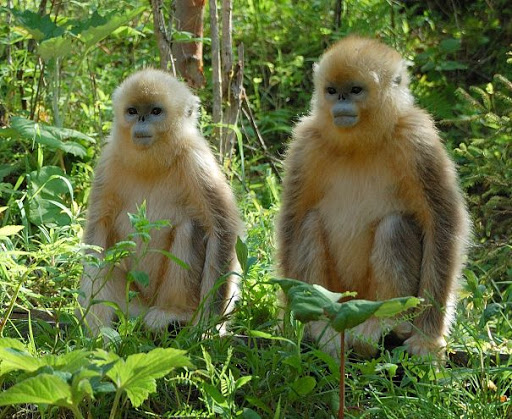

In [24]:
np.array(Image.open(image_paths[0]))

In [25]:
def image_to_array(image_path):
    return np.array(Image.open(image_path))

In [61]:
def detect_objects(image_path):
    image_np = image_to_array(image_path)

    input_tensor = tf.convert_to_tensor(image_np)

    input_tensor = tf.expand_dims(input_tensor, axis=0)

    detections = detect_fcn(input_tensor)

    #pop means extract info and delete
    num_detections = int(detections.pop('num_detections'))

    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}

    detections['num_detections'] = num_detections

    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'],
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates = True,
        max_boxes_to_draw = 200,
        min_score_thresh = 0.3,
        agnostic_mode = False
    )

    plt.figure(figsize = (16, 12))
    plt.imshow(image_np_with_detections)
    plt.show()

In [62]:
image_np = image_to_array(image_paths[3])

input_tensor = tf.convert_to_tensor(image_np)

input_tensor = tf.expand_dims(input_tensor, axis=0)

detections = detect_fcn(input_tensor)

num_detections = int(detections.pop('num_detections'))

In [63]:
detections

{'detection_anchor_indices': <tf.Tensor: shape=(1, 100), dtype=float32, numpy=
 array([[49774., 49025., 49007., 50668., 18527., 50734., 19480., 19967.,
         42623., 49768., 28510., 45773., 43102., 29934., 49624., 48766.,
         48778., 40936., 40690., 49486., 49030., 19973., 49030., 49024.,
         48904., 50729., 42868., 42383., 18041., 50728., 48899., 44573.,
         19973., 48904., 49020., 48772.,  9376., 50740., 49499., 18533.,
         17992., 18934., 49768., 23100., 49768., 48910., 49487., 19482.,
         18466., 19972., 50734., 43348., 18473., 29548., 49654., 29944.,
         49630., 50734., 41177., 49642., 40684., 41165., 49026., 18934.,
         48767., 11361., 48905., 44332., 40931., 44583., 10366., 48898.,
         10362., 48900., 50734., 29548., 48905., 18952., 49654., 42868.,
         50670., 49768., 44579., 19972., 50734., 24864., 20452., 50723.,
         44567., 30420., 50673., 23106., 28510., 50725., 18934., 49654.,
         50734., 19979.,  1931., 48892.]], dt

In [50]:
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

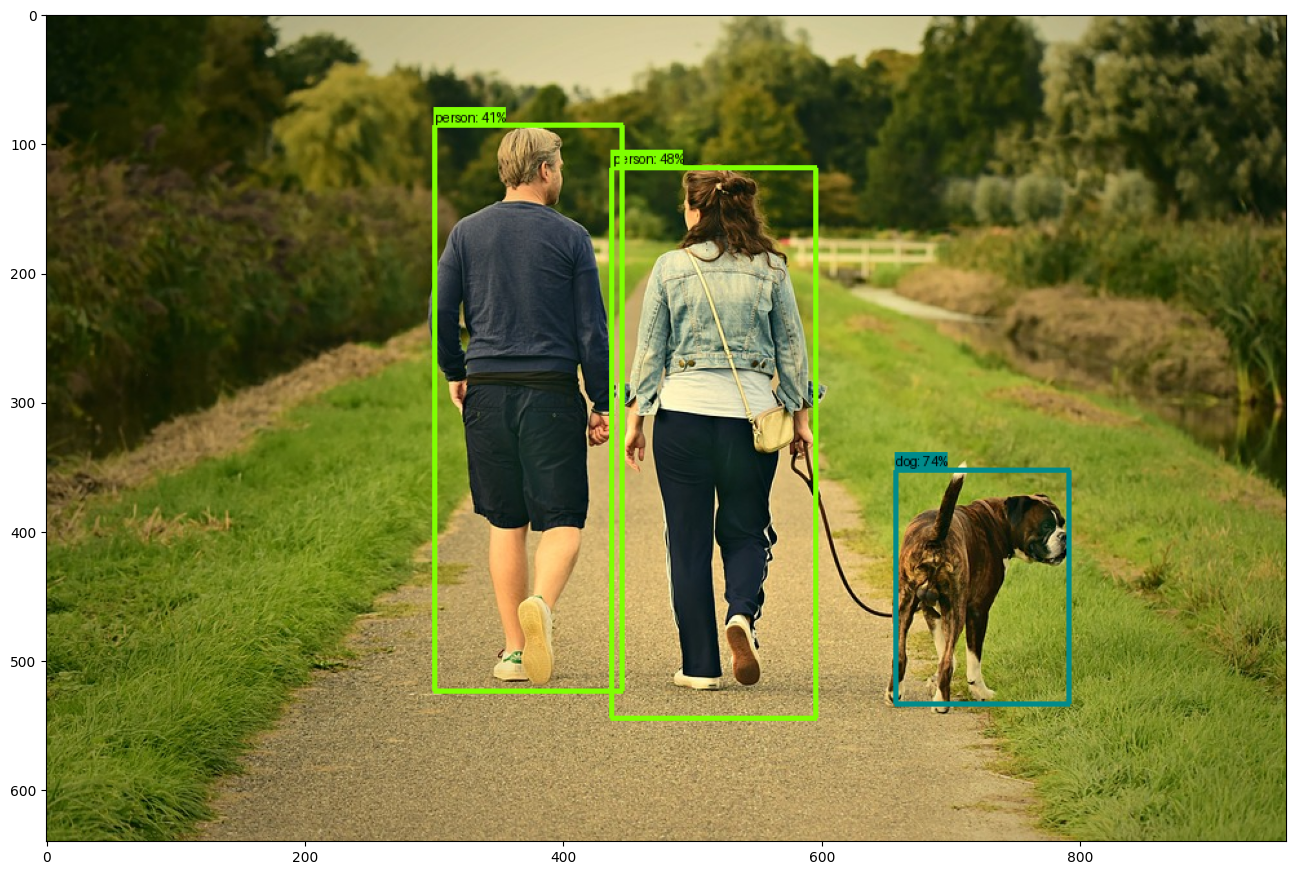

In [64]:
detect_objects(image_paths[3])

##Object Detection for Videos

In [51]:
import imageio

In [53]:
!wget -nc https://lazyprogrammer.me/course_files/cnn_class2_videos.zip

--2025-01-21 10:20:16--  https://lazyprogrammer.me/course_files/cnn_class2_videos.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2073140 (2.0M) [application/zip]
Saving to: ‘cnn_class2_videos.zip’

cnn_class2_videos.z 100%[===================>]   1.98M  8.85MB/s    in 0.2s    

2025-01-21 10:20:17 (8.85 MB/s) - ‘cnn_class2_videos.zip’ saved [2073140/2073140]



In [54]:
!unzip cnn_class2_videos.zip

Archive:  cnn_class2_videos.zip
  inflating: catdog.mp4              
  inflating: safari.mp4              
  inflating: traffic.mp4             


In [55]:
!ls

backgrounds.zip      charmander-tight.png   jungle.jpeg  sample_data	     traffic.mp4
bulbasaur-tight.png  cnn_class2_videos.zip  models	 squirtle-tight.png  walkingdog.jpeg
catdog.mp4	     intersection.jpeg	    safari.mp4	 traffic.jpeg


In [56]:
input_videos = ['catdog', 'safari', 'traffic']

In [75]:
def detect_objects_in_image(image_np):
    #image_np = image_to_array(image_path)

    input_tensor = tf.convert_to_tensor(image_np)

    input_tensor = tf.expand_dims(input_tensor, axis=0)

    detections = detect_fcn(input_tensor)

    #pop means extract info and delete
    num_detections = int(detections.pop('num_detections'))

    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}

    detections['num_detections'] = num_detections

    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'],
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates = True,
        max_boxes_to_draw = 200,
        min_score_thresh = 0.3,
        agnostic_mode = False
    )

    return image_np_with_detections

In [76]:
def detect_objects_in_video(input_video):
    video_reader = imageio.get_reader(f'{input_video}.mp4')
    video_writer = imageio.get_writer(f'{input_video}_annotated.mp4', fps = 10)

    t_0 = time.time()
    n_frames = 0
    for frame in video_reader:
        n_frames += 1
        new_frame = detect_objects_in_image(frame)
        video_writer.append_data(new_frame)

    fps = n_frames / (time.time() - t_0)

    print(f'Frames processed: {n_frames} | FPS: {fps:.2f}')

    video_writer.close()

In [77]:
detect_objects_in_video(input_videos[0])

Frames processed: 50 | FPS: 1.33


In [87]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('catdog_annotated.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

##YOLO